<a href="https://colab.research.google.com/github/adalbertii/Seci-konwolucyjne/blob/main/CNN_plant_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import niezbędnych bibliotek

# przetwarzanie danych
import pandas as pd
import numpy as np
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

import itertools


import traceback

# wizualizacja danych
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# statystyka i modele matematyczne
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest
import math

# selekcja cech
from sklearn.feature_selection import (
    RFECV, SelectKBest, chi2, f_classif, f_regression,
    mutual_info_classif, mutual_info_regression
)

# pipelnie uczenia maszynowego
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin,ClassifierMixin

# Preprocessing danych
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer, FunctionTransformer

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# selekcja optymalnych modeli
from sklearn.model_selection import (
    StratifiedKFold, KFold,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, TimeSeriesSplit
)

# metrykiuczenia maszynowego
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    cohen_kappa_score,
    make_scorer,
    roc_curve,
    auc,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)

# regresory
from sklearn.linear_model import HuberRegressor,RANSACRegressor, TheilSenRegressor, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.ensemble import (
    HistGradientBoostingRegressor, StackingRegressor,
    AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor,
    GradientBoostingRegressor, StackingRegressor, VotingRegressor
    )
#from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


#klasyfikatory
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import (
    HistGradientBoostingClassifier, AdaBoostClassifier,
    RandomForestClassifier, GradientBoostingClassifier,
    StackingClassifier, VotingClassifier,ExtraTreesClassifier
    )
from sklearn.tree import DecisionTreeClassifier
#from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# algorytmy klasterowe
from sklearn.cluster import KMeans

#
#import optuna

#
import random

# Encoder zmiennych kategorycznych
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# OS
import os

#
from PIL import Image

#
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import modułów Keras
from keras.models import Sequential                          # Neural network model as a sequence of layers.
from keras.layers import Conv2D                              # Convolutional layer
from keras.layers import MaxPooling2D                        # Max pooling layer
from keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Dropout                             # This serves to prevent overfitting by dropping out a random set of activations.
from keras.layers import BatchNormalization                  # This is used to normalize the activations of the neurons.
from keras.layers import Activation                          # Layer for activation functions
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit
from keras.models import load_model                          # This helps us to load trained models

# Preprocessing layers
from keras.layers import Rescaling                           # This layer rescales pixel values

# Importing TensorFlow
import tensorflow as tf

In [3]:
# konfiguracja wstępna Notebook-a
seed = 123
paper_color = '#EEF6FF'
bg_color = '#EEF6FF'
#colormap =
#template =

In [4]:
def image_resizer(paths):
    """
    Funkcja zmienia rozmiar obrazów wejściowych
    """
    with ThreadPoolExecutor() as executor:
        resized_images = list(executor.map(lambda x: Image.open(x).resize((350,250)), paths))
    return resized_images

def plot_images_list(images, title, subtitle):
    '''
    Funkcja pomaga wykreślić listę matryc obrazów
    '''
    fig = sp.make_subplots(rows=3, cols=3)
    images = image_resizer(images)

    traces = []
    for i in range(min(9, len(images))):
        img = go.Image(z=images[i])
        traces.append((img, i//3+1, i%3+1))

    fig.add_traces([trace[0] for trace in traces],
                  rows = [trace[1] for trace in traces],
                  cols = [trace[2] for trace in traces])

    fig.update_layout(
        title={'text': f'<b>{title}<br>  <i><sub>{subtitle}</sub></i></b>',
               'font': dict(size = 22)},
        height=800,
        width=800,
        margin=dict(t=110, l=80),
        plot_bgcolor=bg_color,paper_bgcolor=paper_color
    #template=template
    )
    fig.show()

In [5]:
# konfiguracja procesora  GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        print('\nGPU Found! Using GPU...')
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)


GPU Found! Using GPU...


**Załadowanie danych treningowych , walidacyjnych i testowych**

In [6]:
#
train_dir = '/content/drive/MyDrive/dane/Plant/Train'
test_dir = '/content/drive/MyDrive/dane/Plant/Test'
val_dir = '/content/drive/MyDrive/dane/Plant/Validation'

In [8]:
# przypisanie naw do każdego z podkatalogów
directories = {
    train_dir: 'Train',
    test_dir: 'Test',
    val_dir: 'Validation'
    }

#  przypisanie nazw poszczególnym kategoriom klasyfikacyjnym
subfolders = ['Healthy', 'Powdery', 'Rust']
# rust - rdza
# powdery - pyłowata
# healthy - zdrowy

print('\n* * * * * Liczba plików w każdym folderze * * * * *\n')

#
for dir, name in directories.items():
    total = 0
    for sub in subfolders:
        path = os.path.join(dir, sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path, f)])
        total += num_files
        print(f'\n{name}/{sub}: {num_files}')
    print(f'\n  Total: {total}')
    print("-" * 80)


* * * * * Liczba plików w każdym folderze * * * * *


Train/Healthy: 458

Train/Powdery: 430

Train/Rust: 434

  Total: 1322
--------------------------------------------------------------------------------

Test/Healthy: 50

Test/Powdery: 50

Test/Rust: 50

  Total: 150
--------------------------------------------------------------------------------

Validation/Healthy: 20

Validation/Powdery: 20

Validation/Rust: 20

  Total: 60
--------------------------------------------------------------------------------


In [9]:
unique_dimensions = set()

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                unique_dimensions.add(img.size)

if len(unique_dimensions) == 1:
    print(f"\nWszystkie obrazy mają te same wymiary: {unique_dimensions.pop()}")
else:
    print(f"\Znaleziono {len(unique_dimensions)} unikalnych wymiarów obrazu: {unique_dimensions}")

\Znaleziono 8 unikalnych wymiarów obrazu: {(4032, 3024), (4000, 2672), (4000, 3000), (5184, 3456), (2592, 1728), (3901, 2607), (4608, 3456), (2421, 2279)}


In [11]:
# Sprawdzanie, czy wszystkie obrazy w zbiorze danych mają te same wymiary
dims_counts = defaultdict(int)

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                dims_counts[img.size] += 1

for dimension, count in dims_counts.items():
    print(f"\nTyp rozmiaru {dimension}: {count} obrazow")


Typ rozmiaru (4000, 2672): 1130 obrazow

Typ rozmiaru (4000, 3000): 88 obrazow

Typ rozmiaru (2421, 2279): 1 obrazow

Typ rozmiaru (2592, 1728): 127 obrazow

Typ rozmiaru (5184, 3456): 97 obrazow

Typ rozmiaru (4608, 3456): 72 obrazow

Typ rozmiaru (4032, 3024): 16 obrazow

Typ rozmiaru (3901, 2607): 1 obrazow


In [12]:
# Sprawdzanie typó danych opisujących obrazy
all_uint8 = True
all_in_range = True

for dir, name in directories.items():
    for sub in subfolders:
        folder_path = os.path.join(dir, sub)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            with Image.open(image_path) as img:
                img_array = np.array(img)

            if img_array.dtype == 'uint8':
                all_uint8 = False

            if img_array.min() < 0 or img_array.max() > 255:
                all_in_range = False

if all_uint8:
    print(" - Wszystkie obrazy są typu danychuint8\n")
else:
    print(" - Nie wszystkie obrazy są typu danych uint8\n")

if all_in_range:
    print(" - Wszystkie obrazy mają wartości pikseli od 0 do 255")
else:
    print(" - NIE wszystkie obrazy mają wartości pikseli od 0 do 255")

 - Nie wszystkie obrazy są typu danych uint8

 - Wszystkie obrazy mają wartości pikseli od 0 do 255


In [13]:
# Ładowanie katalogu dla każdej klasy w zbiorze danych szkoleniowych
train_healthy_dir = train_dir + "/" + 'Healthy'
train_rust_dir = train_dir + "/" + 'Rust'
train_powdery_dir = train_dir + "/" + 'Powdery'

# Wybór 9 losowych zdjęć każdego katalogu
healthy_files = random.sample(os.listdir(train_healthy_dir), 9)
rust_files = random.sample(os.listdir(train_rust_dir), 9)
powdery_files = random.sample(os.listdir(train_powdery_dir), 9)

In [ ]:
# Obraz zdrowych roślin
healthy_images = [os.path.join(train_healthy_dir, f) for f in healthy_files]
plot_images_list(healthy_images, "Healthy Plants", "Training Dataset")

In [ ]:
#  obraz roślin 'rust'
rust_images = [os.path.join(train_rust_dir, f) for f in rust_files]
plot_images_list(rust_images, "Rust Plants", "Training Dataset")

In [ ]:
#  obraz roslin 'powdery'
powdery_images = [os.path.join(train_powdery_dir, f) for f in powdery_files]
plot_images_list(powdery_images, "Powdery Plants", "Training Dataset")

In [16]:
# budowa zbioru treningowego
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,  # Katalog, w którym znajdują się obrazy szkoleniowe
    labels = 'inferred', # Klasy zostaną wywnioskowane zgodnie ze strukturą katalogu
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,    # Liczba przetworzonych próbek przed aktualizacją wag modelu
    image_size = (256, 256), # Zdefiniowanie stałego wymiaru dla wszystkich obrazów
    shuffle = True,  # Tasowanie danych
    seed = seed,  # Losowe ziarno do tasowania i transformacji
    validation_split = 0, # Nie musimy tworzyć zestawu walidacyjnego na podstawie zestawu szkoleniowego
    crop_to_aspect_ratio = True # Zmiana rozmiaru obrazów bez zniekształcania proporcji
)

Found 1322 files belonging to 3 classes.


In [17]:
# budow zbiosu testowego
test = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,
    image_size = (256, 256),
    shuffle = True,
    seed = seed,
    validation_split = 0,
    crop_to_aspect_ratio = True
)

Found 150 files belonging to 3 classes.


In [18]:
# budowa zbioru walidacyjnego
validation = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,
    image_size = (256, 256),
    shuffle = True,
    seed = seed,
    validation_split = 0,
    crop_to_aspect_ratio = True
)

Found 60 files belonging to 3 classes.


In [19]:
print('\nTreningowy Dataset :', train)
print('\nTestowy Dataset    :', test)
print('\nWalidacyjny Dataset:', validation)


Treningowy Dataset : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

Testowy Dataset    : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

Walidacyjny Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [20]:
# Sprawdzanie minimalnych i maksymalnych wartości pikseli w zestawie da
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimalna wartość piksela w zestawie danych walidacji :', min_value)
print('\nMaksymalna wartość piksela w zestawie danych walidacji:', max_value)


Minimalna wartość piksela w zestawie danych walidacji : 0.0

Maksymalna wartość piksela w zestawie danych walidacji: 255.0


In [21]:
scaler = Rescaling(1./255) # Definicja skalera (wartości docelowe pomiedzy 0 a 1)

In [22]:
# Rescaling zbiorów danych (treningowego, walidacyjnego i testowego)
train = train.map(lambda x, y: (scaler(x), y))
test = test.map(lambda x, y: (scaler(x), y))
validation = validation.map(lambda x, y: (scaler(x), y))

In [23]:
# Sprawdzanie minimalnych i maksymalnych wartości pikseli w zestawie danych walidacji
min_value = float('inf')
max_value = -float('inf')

for img, label in validation:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimalna wartość piksela w zbiorze walidacyjnym  :', min_value)
print('\nMaksymalna wartość piksela w zbiorze walidacyjnym :', max_value)


Minimalna wartość piksela w zbiorze walidacyjnym  : 0.0

Maksymalna wartość piksela w zbiorze walidacyjnym : 1.0


In [24]:
# Tworzenie potoku augmentacji danych


augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
        factor = (-.25, .3),
        fill_mode = 'reflect',
        interpolation = 'bilinear',
        seed = seed),


        tf.keras.layers.RandomBrightness(
        factor = (-.45, .45),
        value_range = (0.0, 1.0),
        seed = seed),

        tf.keras.layers.RandomContrast(
        factor = (.5),
        seed = seed)
    ]
)

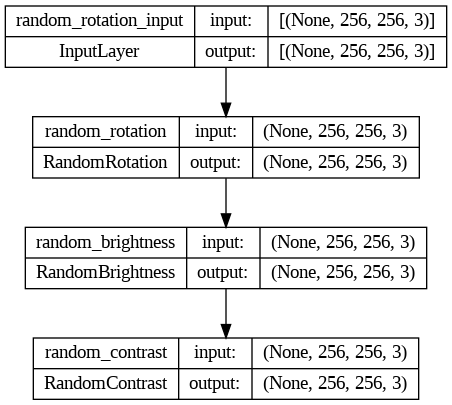

In [25]:
# budowa modelu
augmentation.build((None, 256, 256, 3))


# obraz modeluaugmentacyjnego
tf.keras.utils.plot_model(augmentation,
                          show_shapes = True,
                          show_layer_names = True,
                          expand_nested = True)

In [43]:
# definicja pełnego modelu
with strategy.scope():
    model = Sequential()

    model.add(augmentation) # Dodanie potoku augmentacji danych do modelu

    # warstwy ekstrakcji cech
    model.add(Conv2D(32,                  # liczba filtrów(Kernels)
                     (3,3),               # rozmiar filtru (3x3 matrix)
                     strides = 1,         # Rozmiar kroku przesuwania filtra po obrazie (1 piksel na raz).
                     padding = 'same',    # Opcja „Same” gwarantuje, że wyjściowa mapa funkcji będzie miała takie same wymiary jak dane wejściowe, poprzez dopełnienie zerami wokół danych wejściowych.
                    input_shape = (256,256,3) # rozmiar zdjęcia wejściowego
                    ))
    model.add(Activation('relu'))#
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (5,5), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
    model.add(Dropout(0.3))

    # spłaszczanie tensorów
    model.add(Flatten())

    # W pełni połączone warstwy
    model.add(Dense(2048))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # warstwa wyjściowa (klasyfikacytjna)
    model.add(Dense(3, activation = 'softmax'))

In [44]:
# kompilacja  modelu
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), # 1e-4
              loss = 'categorical_crossentropy', # Idealny do zadań wieloklasowych
              metrics = ['accuracy']) # metryka procesu uczenia (modelu)

In [45]:
# definicja 'Early Stopping' Checkpoints
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

In [46]:
# proces uczenia


import time

tic = time.time()

try:
    history = model.fit(
        train, epochs = 50,
        validation_data = test,
        callbacks = [early_stopping, checkpoint])
except Exception as e:
    print("An error occurred:", e)

toc = time.time()
print('Czas procesu uczenia modelu: {}'.format(toc - tic))

Epoch 1/50
83/83 [==============================] - 80s 847ms/step - loss: 5.5733 - accuracy: 0.5333 - val_loss: 4.8774 - val_accuracy: 0.3333
Epoch 2/50
83/83 [==============================] - 66s 712ms/step - loss: 2.3529 - accuracy: 0.6278 - val_loss: 5.6586 - val_accuracy: 0.3333
Epoch 3/50
83/83 [==============================] - 71s 801ms/step - loss: 1.6671 - accuracy: 0.6694 - val_loss: 6.1938 - val_accuracy: 0.4800
Epoch 4/50
83/83 [==============================] - 65s 723ms/step - loss: 1.1459 - accuracy: 0.7262 - val_loss: 15.7576 - val_accuracy: 0.3333
Epoch 5/50
83/83 [==============================] - 64s 716ms/step - loss: 0.8078 - accuracy: 0.7587 - val_loss: 7.6553 - val_accuracy: 0.3867
Epoch 6/50
83/83 [==============================] - 65s 707ms/step - loss: 0.7150 - accuracy: 0.7897 - val_loss: 7.4772 - val_accuracy: 0.3800
Epoch 7/50
83/83 [==============================] - 72s 798ms/step - loss: 0.6806 - accuracy: 0.8169 - val_loss: 4.2182 - val_accuracy: 0.586

In [47]:
import matplotlib.pyplot as plt
def make_accuracy_plot(history):
    """
    Funkcja zwraca wykres dokładności modelu na zestawie treningowym
    i walidacyjnym.
    """
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 8))
    plt.plot(epochs, acc, label='Accuracy of training', marker='o')
    plt.plot(epochs, val_acc, label='Validation accuracy', marker='o')
    plt.legend()
    plt.title('Accuracy of training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

def make_loss_plot(history):
    """
    Funkcja zwraca wykres strat modelu na zestawie treningowym
    i walidacyjnym.
    """
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 8))
    plt.plot(epochs, loss, label='Training loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation loss', marker='o')
    plt.legend()
    plt.title('Loss of training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

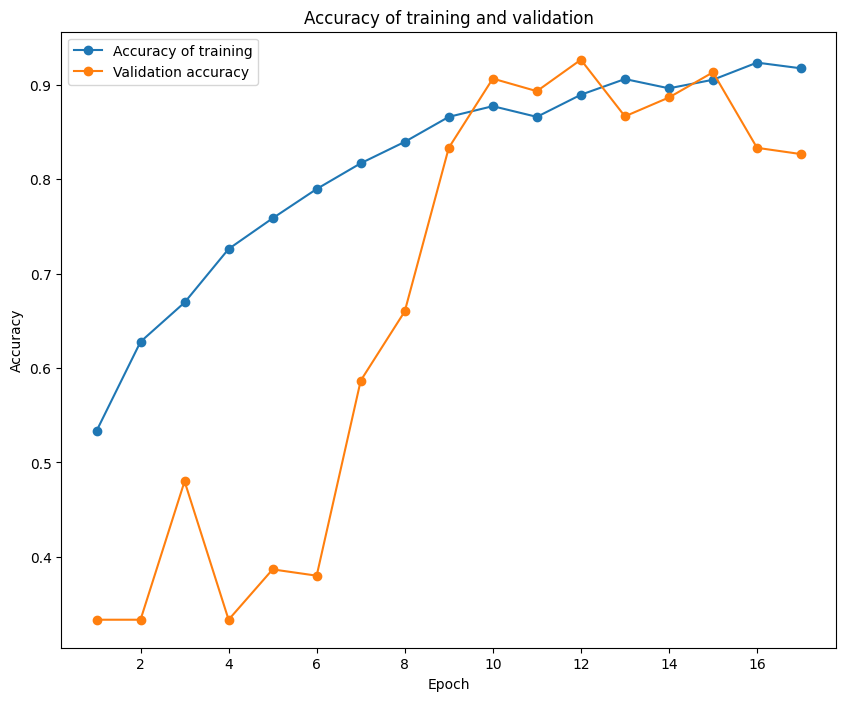

In [48]:
make_accuracy_plot(history)

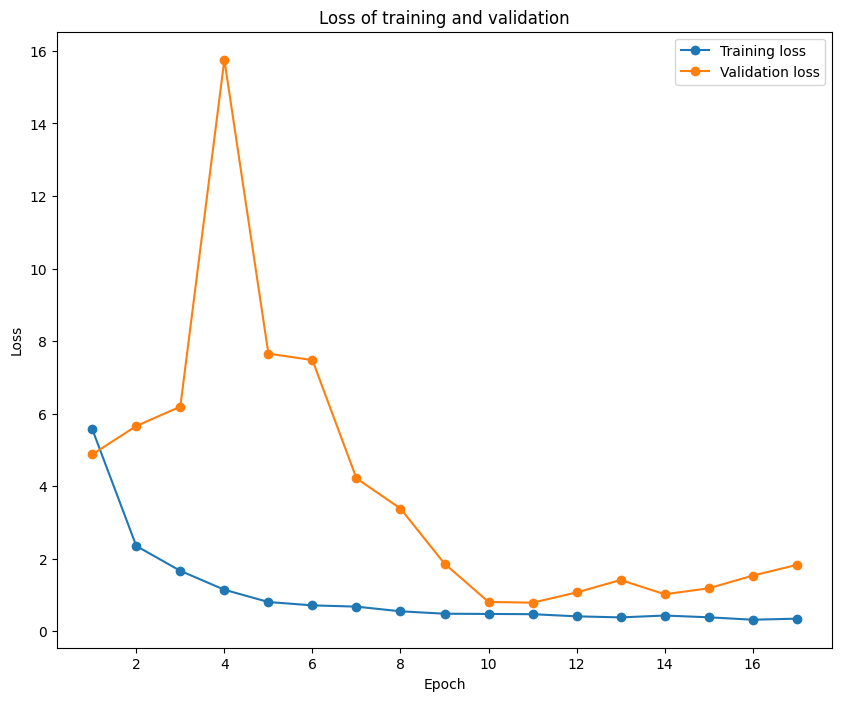

In [49]:
make_loss_plot(history)

In [ ]:
# tworzenie matrycy wykresów
fig = make_subplots(rows=1,
                    cols=2,
                    subplot_titles=['<b>Loss Over Epochs</b>', '<b>Accuracy Over Epochs</b>'],
                    horizontal_spacing=0.2)

# strata dla każdej epoki
train_loss = go.Scatter(x=list(range(len(history.history['loss']))),
                        y=history.history['loss'],
                        mode='lines',
                        line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                        name='Training',
                        showlegend = False)

val_loss = go.Scatter(x=list(range(len(history.history['val_loss']))),
                      y=history.history['val_loss'],
                      mode='lines',
                      line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                      name='Test',
                      showlegend = False)


fig.add_trace(train_loss, row=1, col=1)
fig.add_trace(val_loss, row=1, col=1)

# Accuray dla każdej epoki
train_acc = go.Scatter(x=list(range(len(history.history['accuracy']))),
                       y=history.history['accuracy'],
                       mode='lines',
                       line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                       name='Training',
                       showlegend = True)

val_acc = go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                     y=history.history['val_accuracy'],
                     mode='lines',
                     line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                     name='Test',
                     showlegend = True)


fig.add_trace(train_acc, row=1, col=2)
fig.add_trace(val_acc, row=1, col=2)

#
fig.update_layout(
    title={'text': '<b>Loss and Accuracy Over Epochs</b>', 'x': 0.025, 'xanchor': 'left'},
    margin=dict(t=100),
    plot_bgcolor=bg_color,paper_bgcolor=paper_color,
    height=500, width=1000,
    showlegend= True
)

fig.update_yaxes(title_text = 'Loss', row = 1, col = 1)
fig.update_yaxes(title_text = 'Accuracy', row = 1, col = 2)

fig.update_xaxes(title_text = 'Epoch', row = 1, col = 1)
fig.update_xaxes(title_text = 'Epoch', row = 1, col = 2)

#
fig.show()

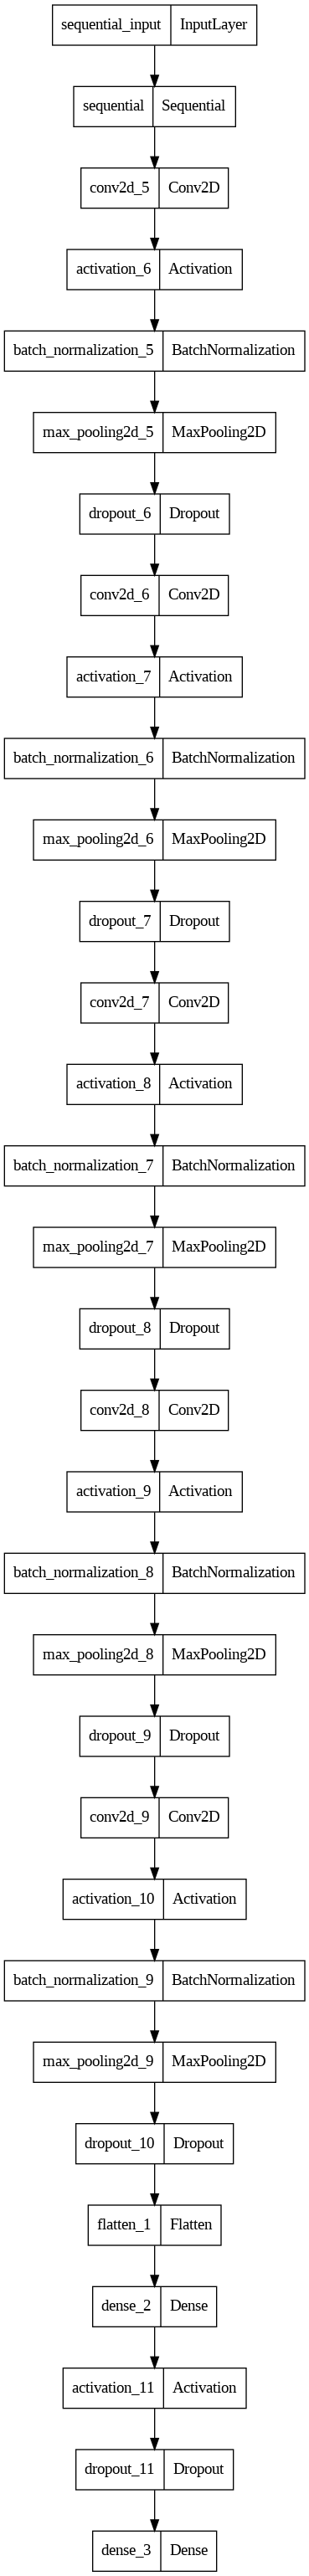

In [50]:
tf.keras.utils.plot_model(model) #

In [51]:
model.summary() #

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_5 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 128, 128, 32)     

**##########################################################################**


**Predykcja na bazie zapisanego wcześniej modelu (wyuczonego)**

In [52]:
# załadowanie modelu (z callbacka)
model.load_weights('best_model.h5')

In [53]:
preds = model.predict(validation)  # predykcja na zbiorze walidacyjnym
val_loss, val_acc = model.evaluate(validation) # Obtaining Loss and Accuracy on the val dataset

print('\nStrata na zbiorze walidacyjnym   : ', val_loss)
print('\nAccuracy na zbiorze walidacyjnym : ', np.round(val_acc * 100), '%')

4/4 [==============================] - 3s 26ms/step - loss: 1.6102 - accuracy: 0.8833

Strata na zbiorze walidacyjnym   :  1.6102017164230347

Accuracy na zbiorze walidacyjnym :  88.0 %


Obraz rośliny z "Picture": 



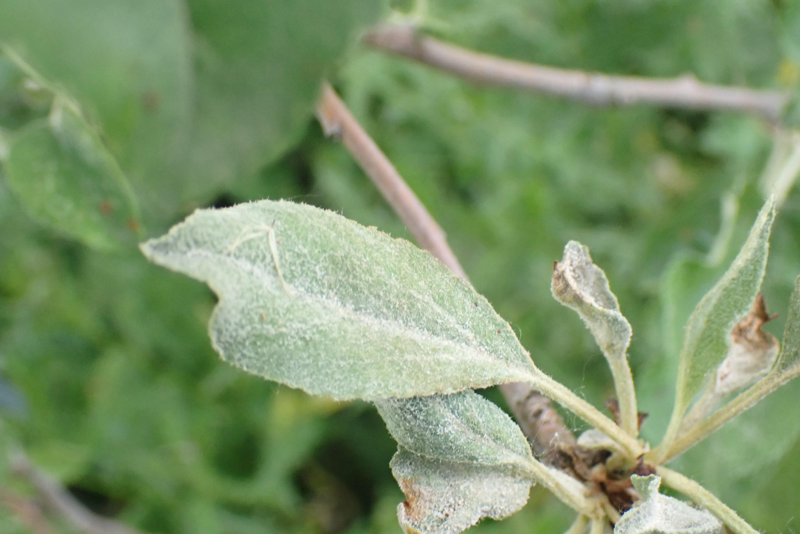

In [54]:
# Ładowanie obrazu z katalogu Validation/ Powdery
image_path = '/content/drive/MyDrive/dane/Plant/Validation/Powdery/9b6a318cc5721d73.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Zmiana rozmiaru obrazu w celu uzyskania optymalnej wydajności
new_width = int(og_width * .20) # 20% orginalnego rozmiaru
new_height = int(og_height * .20) # 20% orginalnego rozmiaru

resized_img = original_image.resize((new_width, new_height))
print('Obraz rośliny z "Powdery": \n')
resized_img

In [55]:
# Ręczne wstępne przetwarzanie obrazu
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\n Wynik predykcji (klasa)      : {preds_label}')
print(f'\n Wskaznik pewnosci predykcji  : {preds[0][preds_class]}')

1/1 [==============================] - 0s 205ms/step

 Wynik predykcji (klasa)      : Powdery

 Wskaznik pewnosci predykcji  : 1.0


Obraz rosliny z "Rust" : 



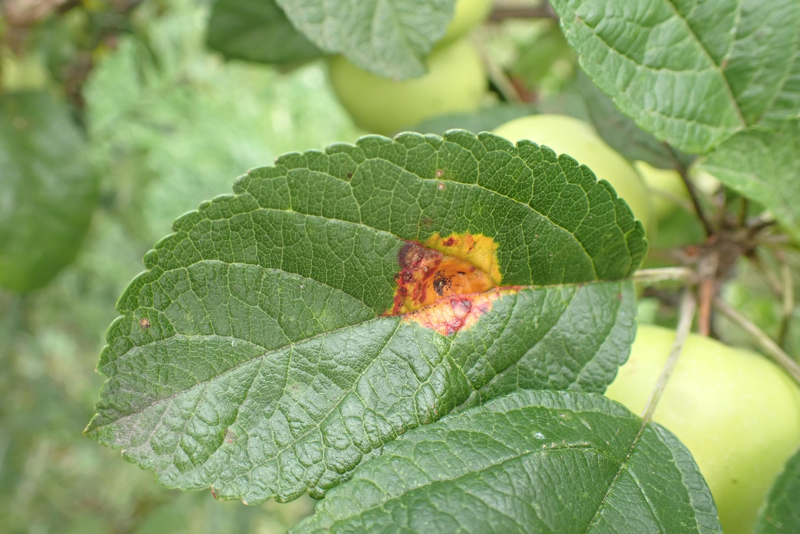

In [56]:
# załadowanie obrazu z katalogu Validation/ Rust
image_path = '/content/drive/MyDrive/dane/Plant/Validation/Rust/8152cfbd5a28b5d2.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing obrazu
new_width = int(og_width * .20) # 20% of the original size
new_height = int(og_height * .20) # 20% of the original size

resized_img = original_image.resize((new_width, new_height))
print('Obraz rosliny z "Rust" : \n')
resized_img

In [57]:
# ręczny preprocessing obrazu
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nWynik predykcji (klasa)      : {preds_label}')
print(f'\nWskaznik pewnosci predykcji  : {preds[0][preds_class]}')

1/1 [==============================] - 0s 74ms/step

Wynik predykcji (klasa)      : Rust

Wskaznik pewnosci predykcji  : 1.0


Obraz zdrowej rośliny : 



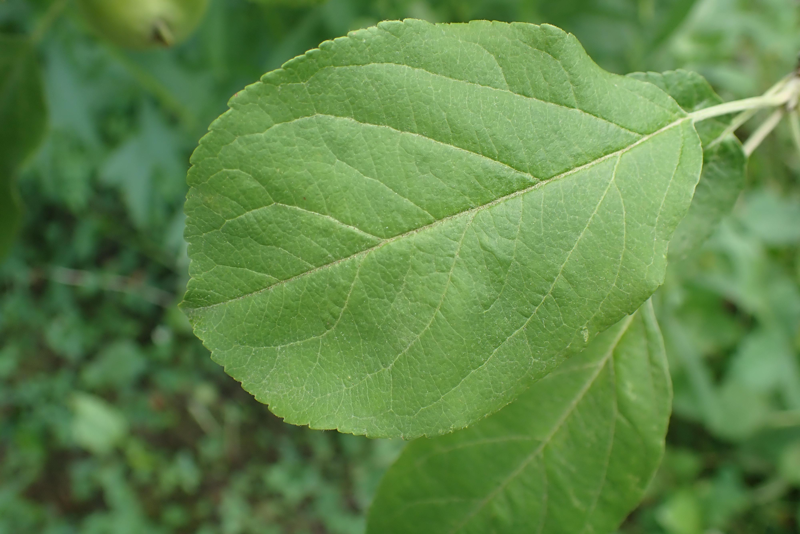

In [58]:
# załadowanie obrazu z katalogu Validation/ Healthy
image_path = '/content/drive/MyDrive/dane/Plant/Validation/Healthy/9c99786a63786571.jpg'
original_image = Image.open(image_path)
og_width, og_height = original_image.size

# Resizing obrazu
new_width = int(og_width * .20) # 20%
new_height = int(og_height * .20) # 20%

resized_img = original_image.resize((new_width, new_height))
print('Obraz zdrowej rośliny : \n')
resized_img

In [59]:
# ręczny preprocessing obrazu
preprocessed_image = original_image.resize((256, 256))
preprocessed_image = np.array(preprocessed_image) / 255.0

preds = model.predict(np.expand_dims(preprocessed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

preds_class = np.argmax(preds)
preds_label = labels[preds_class]

print(f'\nWynik predykcji (klasa)      : {preds_label}')
print(f'\nWskaznik pewnosci predykcji  : {preds[0][preds_class]}')

1/1 [==============================] - 0s 101ms/step

Wynik predykcji (klasa)      : Healthy

Wskaznik pewnosci predykcji  : 0.999994158744812


In [60]:
#ostateczne  zapisanie modelu
model.save('plant_disease_classifier.h5')